<a href="https://colab.research.google.com/github/Apikmmar/term-deposit-prediction/blob/main/project_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import sys
!{sys.executable} -m pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
# install fuzzy package
!pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
%cd "/content/drive/MyDrive/bank-marketing"

/content/drive/MyDrive/bank-marketing


In [51]:
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
import pandas as pd

from skfuzzy import control as ctrl
from numpy import genfromtxt

In [52]:
dataset = pd.read_csv('bank-additional.csv', sep=',')
dataset.head()

age          job  marital          education default  housing     loan  \
0   30  blue-collar  married           basic.9y      no      yes       no   
1   39     services   single        high.school      no       no       no   
2   25     services  married        high.school      no      yes       no   
3   38     services  married           basic.9y      no  unknown  unknown   
4   47       admin.  married  university.degree      no      yes       no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0   cellular   may         fri  ...         2    999         0  nonexistent   
1  telephone   may         fri  ...         4    999         0  nonexistent   
2  telephone   jun         wed  ...         1    999         0  nonexistent   
3  telephone   jun         fri  ...         3    999         0  nonexistent   
4   cellular   nov         mon  ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0         -1.8          92.893          -46.2      1.313       5099.1  no  
1          1.1          93.994          -36.4      4.855       5191.0  no  
2          1.4          94.465          -41.8      4.962       5228.1  no  
3          1.4          94.465          -41.8      4.959       5228.1  no  
4         -0.1          93.200          -42.0      4.191       5195.8  no  

[5 rows x 21 columns]

In [53]:
# delete unwanted attribute
del dataset['age']
del dataset['job']
del dataset['marital']
del dataset['education']
del dataset['default']
del dataset['contact']
del dataset['month']
del dataset['pdays']
del dataset['duration']
del dataset['day_of_week']
del dataset['campaign']
del dataset['previous']
del dataset['poutcome']
del dataset['nr.employed']
del dataset['emp.var.rate']
del dataset['cons.conf.idx']


print(dataset.columns.tolist())

['housing', 'loan', 'cons.price.idx', 'euribor3m', 'y']


In [54]:
# convert categorial input from string to int
dataset['housing'] = dataset['housing'].map({
    'yes': 1,
    'unknown': 0.5,
    'no': 0
})

dataset['loan'] = dataset['loan'].map({
    'yes': 1,
    'unknown': 0.5,
    'no': 0
})

dataset['y'] = dataset['y'].map({
    'yes': 1,
    'no': 0
})

In [55]:
# Antecent
housing = ctrl.Antecedent(np.arange(-1, 1, 0.5), 'housing')
loan = ctrl.Antecedent(np.arange(-1, 1, 0.5), 'loan')
cpi = ctrl.Antecedent(np.arange(dataset['cons.price.idx'].min(), dataset['cons.price.idx'].max(), 1), 'cons.price.idx')
epi = ctrl.Antecedent(np.arange(dataset['euribor3m'].min(), dataset['euribor3m'].max(), 1), 'euribor3m')
subs = ctrl.Consequent(np.arange(dataset['y'].min(), dataset['y'].max(), 0.5), 'y', defuzzify_method='centroid')

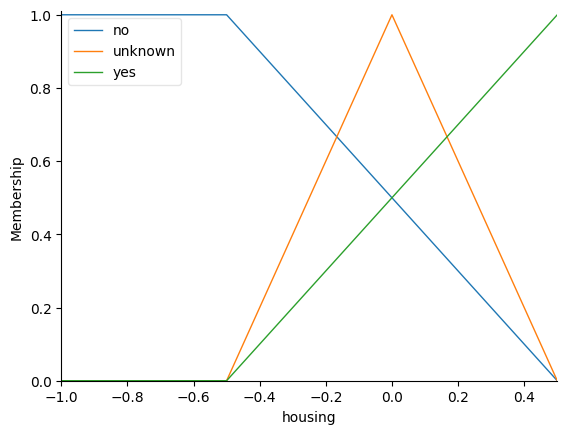

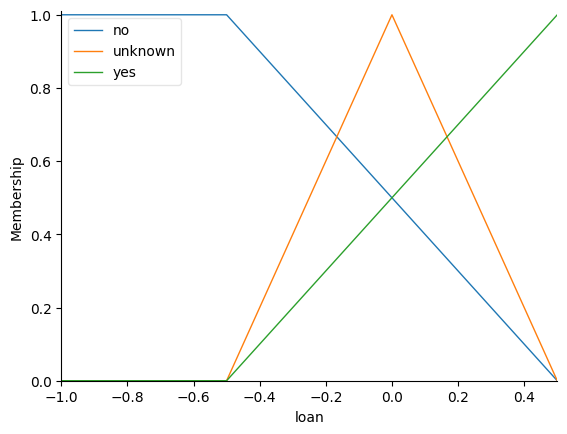

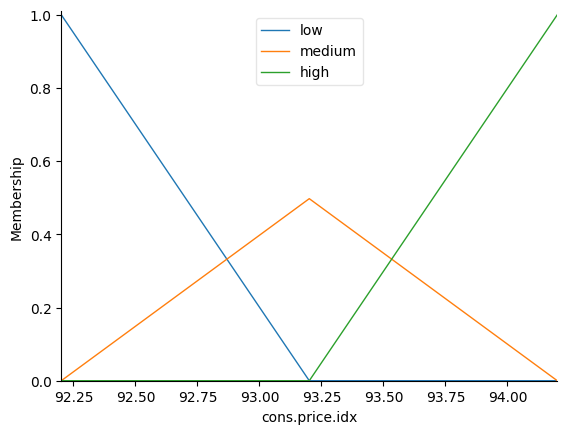

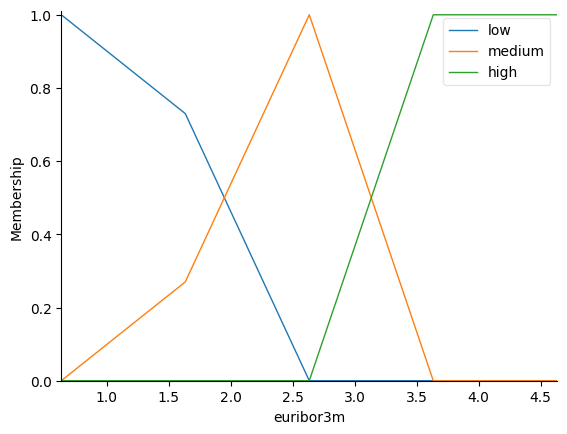

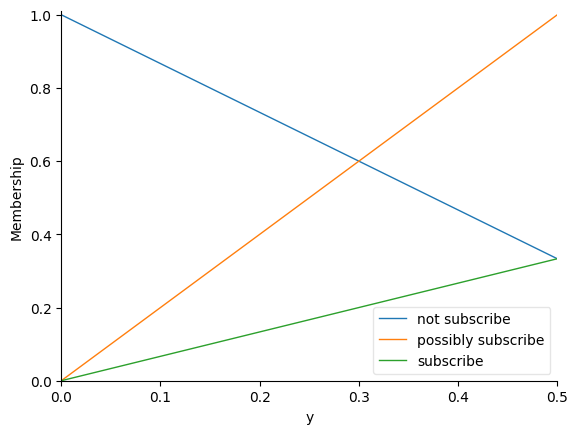

In [56]:
# housing membership function
housing['no'] = fuzz.trapmf(housing.universe, [-1, -1, -0.3, 0.3])
housing['unknown'] = fuzz.trimf(housing.universe, [-0.5, 0, 0.5])
housing['yes'] = fuzz.trapmf(housing.universe, [-0.3, 0.3, 1, 1])

# loan membership function
loan['no'] = fuzz.trapmf(loan.universe, [-1, -1, -0.3, 0.3])
loan['unknown'] = fuzz.trimf(loan.universe, [-0.5, 0, 0.5])
loan['yes'] = fuzz.trapmf(loan.universe, [-0.3, 0.3, 1, 1])

# cpi membership function
cpi['low'] = fuzz.trapmf(cpi.universe, [92., 92., 92.5, 92.8])
cpi['medium'] = fuzz.trimf(cpi.universe, [92.8, 93.0, 93.4])
cpi['high'] = fuzz.trapmf(cpi.universe, [93.4, 94., dataset['cons.price.idx'].max(), dataset['cons.price.idx'].max()])

# epi membership function
epi['low'] = fuzz.trapmf(epi.universe, [0, 0, 1.5, 2.])
epi['medium'] = fuzz.trapmf(epi.universe, [1.5, 2., 3., 3.5])
epi['high'] = fuzz.trapmf(epi.universe, [3., 3.5, dataset['euribor3m'].max(), dataset['euribor3m'].max()])

# subs membership function
subs['not subscribe'] = fuzz.trapmf(subs.universe, [0, 0, 0.3, 0.6])
subs['possibly subscribe'] = fuzz.trapmf(subs.universe, [0.4, 0.45, 0.55, 0.6])
subs['subscribe'] = fuzz.trapmf(subs.universe, [0.4, 0.7, 1.0, 1.0])

# view membership function
housing.view()
loan.view()
cpi.view()
epi.view()
subs.view()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

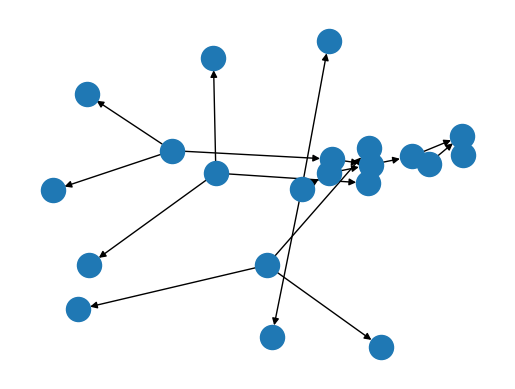

In [57]:
rule1 = ctrl.Rule(housing['no'] & loan['no'] & cpi['low'] & epi['low'], subs['not subscribe'])

subs_ctrl = ctrl.ControlSystem([
    rule1,
    ctrl.Rule(housing['no'] & loan['no'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['medium'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['high'] & epi['medium'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['no'] & loan['yes'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['medium'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['yes'] & loan['no'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['medium'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['medium'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['medium'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['high'] & epi['medium'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['high'] & epi['high'], subs['not subscribe']),
])

subs_predict = ctrl.ControlSystemSimulation(subs_ctrl)

rule1.view()

In [60]:
# subscribe
subs_predict.input['housing'] = 1
subs_predict.input['loan'] = 0
subs_predict.input['cons.price.idx'] = 94.1
subs_predict.input['euribor3m'] = 1.3

subs_predict.compute()

0.2749867307921446


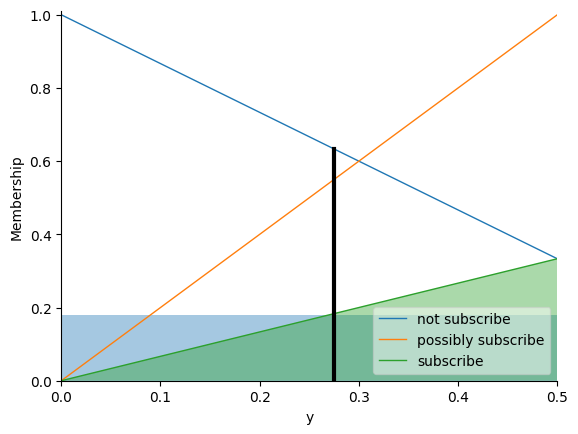

In [61]:
print(subs_predict.output['y'])
subs.view(sim=subs_predict)